# Trainning
In this notebook, we focus on building and evaluating machine learning models to predict patients with chronic diseases, using the enhanced dataset `alexis_training.csv`. The goal is to leverage the features created during the feature engineering process to develop robust models that can assist in reducing healthcare costs and implementing preventive care strategies.


### Key Objectives:

1. **Model Selection and Training**: Train multiple machine learning models, including Logistic Regression, Random Forest, and a third selected model, to determine the best-performing algorithm.
2. **Evaluation**: Use various metrics (accuracy, precision, recall, F1-score, etc.) to evaluate model performance, ensuring alignment with the project's objectives.
3. **Optimization**: Address potential challenges such as class imbalance by implementing techniques like weighted classes and resampling, enhancing model reliability.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import cross_val_predict, cross_val_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import pickle
from xgboost import XGBClassifier


## Data Loading

In [2]:
# Load the training dataset
train_df = pd.read_csv("alexis_train.csv")

In [3]:
# Separate features (X) and target (y)
X_train = train_df.drop(columns=["Chronic_Condition"])
y_train = train_df["Chronic_Condition"]

### Random Forest as the First Model

Random Forest is a versatile and robust ensemble learning method that constructs multiple decision trees during training and merges their outputs for improved accuracy and stability. By leveraging bootstrap aggregation (bagging), it reduces overfitting and enhances generalization. Random Forest excels at handling large datasets, accommodating both numerical and categorical variables, and providing insights through feature importance analysis.

Key features include its ability to manage class imbalance via class weighting, regularization to prevent overfitting, and strong performance on diverse datasets. These strengths, coupled with its simplicity and interpretability, make Random Forest a suitable choice for this project's objectives.

**Citation**: [Random Forest Documentation](https://scikit-learn.org/stable/modules/ensemble.html#random-forests)


In [4]:
model = RandomForestClassifier(class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [5]:
print("Training Accuracy:", model.score(X_train, y_train))

Training Accuracy: 0.9999868146357543


In [6]:
# Predict on test set
y_pred = model.predict(X_train)

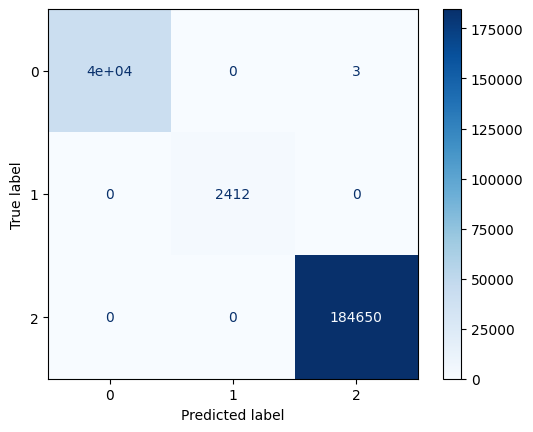

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.show()

In [8]:
# Accuracy
accuracy = accuracy_score(y_train, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9999868146357543


In [9]:
# Classification report
print("Classification Report:")
print(classification_report(y_train, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40463
           1       1.00      1.00      1.00      2412
           2       1.00      1.00      1.00    184650

    accuracy                           1.00    227525
   macro avg       1.00      1.00      1.00    227525
weighted avg       1.00      1.00      1.00    227525



The results indicate that the model is still overfitting to the training data despite. The near-perfect precision, recall, and F1-scores across all classes confirm that the model has memorized the training data, which could result in poor generalization to unseen data.

### Next Step: Regularization

To address this issue, you should proceed with regularizing the Random Forest model. Regularization will help control the model's complexity and prevent overfitting. You can implement the following adjustments:

- **Limit Tree Depth**: Set the `max_depth` parameter to restrict the depth of each tree.
- **Control Features**: Use `max_features` to limit the number of features considered for splitting at each node.
- **Increase Minimum Samples**: Adjust `min_samples_split` and `min_samples_leaf` to ensure splits and leaves contain sufficient data points.

1. Scikit-learn Documentation: [RandomForestClassifier Regularization Parameters](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron: Discusses tuning hyperparameters like `max_depth`, `max_features`, and `min_samples_split` to prevent overfitting.
3. Towards Data Science: [How to Tune Random Forest Hyperparameters](https://towardsdatascience.com/how-to-tune-a-random-forest-hyperparameter-6e8cf570db5c)

In [10]:
# Regularize Random Forest
regularized_model = RandomForestClassifier(random_state=42, 
                                           max_depth=10,  # Start with a moderate depth
                                           min_samples_split=10,  # Minimum samples to split
                                           min_samples_leaf=5,    # Minimum samples per leaf
                                           class_weight="balanced")  # Handle class imbalance

In [11]:
# Train the model
regularized_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [12]:
# Evaluate on training set
y_pred_train = regularized_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.5378


The drastic drop in training accuracy (from nearly 100% to 53.78%) indicates that the model is no longer learning effectively from the training data. It seems that the applied regularization caused underfitting

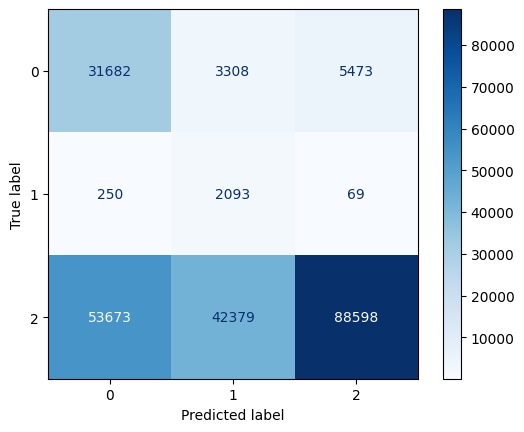

In [13]:
# Generate confusion matrix
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=regularized_model.classes_)
disp.plot(cmap="Blues") 
plt.show()

In [14]:
# Classification report
print("Classification Report:")
print(classification_report(y_train, y_pred_train))

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.78      0.50     40463
           1       0.04      0.87      0.08      2412
           2       0.94      0.48      0.64    184650

    accuracy                           0.54    227525
   macro avg       0.45      0.71      0.41    227525
weighted avg       0.83      0.54      0.61    227525



The initial Random Forest model underperformed due to overly restrictive regularization settings. Adjustments were made in the updated version to improve performance:

1. **Increased `max_depth`**:
   - Original: `max_depth=10`
   - Updated: `max_depth=30`
   - Allowed the model to capture more complex patterns by increasing the depth of each tree.

2. **Reduced `min_samples_leaf`**:
   - Original: `min_samples_leaf=5`
   - Updated: `min_samples_leaf=2`
   - Enabled the model to have more splits, increasing granularity for predictions.

3. **Maintained `min_samples_split`**:
   - Consistently set to `min_samples_split=10`, ensuring enough samples are required to perform a split.

These changes balanced complexity and model performance, addressing underfitting in the initial version while still managing overfitting through regularization.

In [15]:
# Regularize Random Forest
regularized_model = RandomForestClassifier(random_state=42, 
                                           max_depth=30,  # Start with a moderate depth
                                           min_samples_split=10,  # Minimum samples to split
                                           min_samples_leaf=2,    # Minimum samples per leaf
                                           class_weight="balanced")  # Handle class imbalance

In [16]:
regularized_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=2, min_samples_split=10,
                       random_state=42)

In [17]:
# Evaluate on training set
y_pred_train = regularized_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.9412


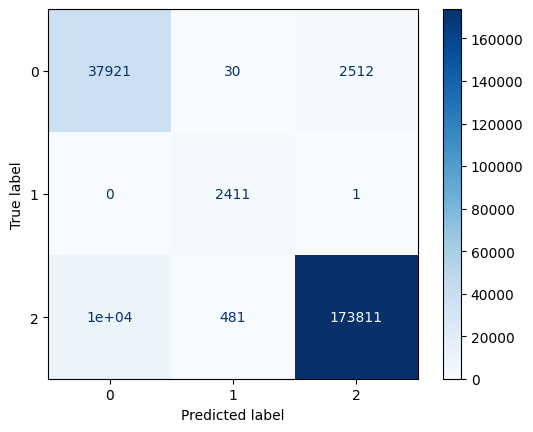

In [18]:
# Generate confusion matrix
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=regularized_model.classes_)
disp.plot(cmap="Blues") 
plt.show()

In [19]:
# Classification report
print("Classification Report:")
print(classification_report(y_train, y_pred_train))

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.85     40463
           1       0.83      1.00      0.90      2412
           2       0.99      0.94      0.96    184650

    accuracy                           0.94    227525
   macro avg       0.87      0.96      0.91    227525
weighted avg       0.95      0.94      0.94    227525



### Regularized Random Forest Highlights

- **Accuracy:** ~94%
- **Strengths:** Balances simplicity and performance, uses feature importance to interpret results, and manages overfitting through regularization.
- **Precision & Recall:** Strong performance across all classes, especially class 1 (with a perfect recall).

### Hyperparameter Testing for Random Forest

To optimize the performance of the Random Forest model, we tested various combinations of hyperparameters:

- **Parameters Tested:**
  - `max_depth`: Controls the maximum depth of each tree to prevent overfitting.
  - `min_samples_split`: Ensures a minimum number of samples is required to split an internal node.
  - `min_samples_leaf`: Defines the minimum number of samples allowed in a leaf node.

- **Why This Approach?**
  - Systematically varying these parameters helps identify the combination that balances model complexity and accuracy.
  - Testing different hyperparameter values allows for a better understanding of the model's behavior and aids in fine-tuning for optimal performance.

- **Evaluation:**
  - The training accuracy was calculated for each combination to assess the model's performance.
  - Insights gained from this process guide further regularization and model refinement.

In [20]:
max_depth_values = [20, 30, 40]
min_samples_split_values = [10, 15]
min_samples_leaf_values = [2, 3]

for depth in max_depth_values:
    for split in min_samples_split_values:
        for leaf in min_samples_leaf_values:
            print(f"Testing max_depth={depth}, min_samples_split={split}, min_samples_leaf={leaf}")
            model = RandomForestClassifier(
                random_state=42,
                max_depth=depth,
                min_samples_split=split,
                min_samples_leaf=leaf,
                class_weight="balanced"
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_train)
            accuracy = accuracy_score(y_train, y_pred)
            print(f"Training Accuracy: {accuracy:.4f}")


Testing max_depth=20, min_samples_split=10, min_samples_leaf=2
Training Accuracy: 0.8461
Testing max_depth=20, min_samples_split=10, min_samples_leaf=3
Training Accuracy: 0.8341
Testing max_depth=20, min_samples_split=15, min_samples_leaf=2
Training Accuracy: 0.8235
Testing max_depth=20, min_samples_split=15, min_samples_leaf=3
Training Accuracy: 0.8145
Testing max_depth=30, min_samples_split=10, min_samples_leaf=2
Training Accuracy: 0.9412
Testing max_depth=30, min_samples_split=10, min_samples_leaf=3
Training Accuracy: 0.9213
Testing max_depth=30, min_samples_split=15, min_samples_leaf=2
Training Accuracy: 0.9078
Testing max_depth=30, min_samples_split=15, min_samples_leaf=3
Training Accuracy: 0.8914
Testing max_depth=40, min_samples_split=10, min_samples_leaf=2
Training Accuracy: 0.9483
Testing max_depth=40, min_samples_split=10, min_samples_leaf=3
Training Accuracy: 0.9266
Testing max_depth=40, min_samples_split=15, min_samples_leaf=2
Training Accuracy: 0.9142
Testing max_depth=40,

In [ ]:
cv_scores = cross_val_score(
    RandomForestClassifier(random_state=42, max_depth=40, min_samples_split=10, min_samples_leaf=2, class_weight="balanced"),
    X_train, y_train, cv=5
)
print("Cross-Validation Accuracy:", cv_scores.mean())

Cross-Validation Accuracy: 0.8030282386550928


In [ ]:
# Get cross-validated predictions
cv_predictions = cross_val_predict(
    RandomForestClassifier(random_state=42, max_depth=40, min_samples_split=10, min_samples_leaf=2, class_weight="balanced"),
    X_train, y_train, cv=5
)

# Generate classification report
print(classification_report(y_train, cv_predictions))

              precision    recall  f1-score   support

           0       0.48      0.50      0.49     40463
           1       0.12      0.00      0.01      2412
           2       0.88      0.88      0.88    184650

    accuracy                           0.80    227525
   macro avg       0.49      0.46      0.46    227525
weighted avg       0.80      0.80      0.80    227525



The hyperparameter-tuned Random Forest model did not perform as expected, with an accuracy of 80% and suboptimal precision and recall for classes 0 and 1. As a result, we are reverting to the regularized Random Forest model, which demonstrated superior performance. Moving forward, we will also explore the potential of an XGBoost model to further improve predictive accuracy and robustness.


### Alternative Model XGboost

XGBoost is a powerful and efficient implementation of the gradient boosting algorithm, designed to optimize speed and performance. It builds an ensemble of decision trees sequentially, with each tree learning from the errors of the previous one. Key features include support for regularization, handling of missing data, and scalability for large datasets.  
**Citation**: [XGBoost Documentation](https://xgboost.readthedocs.io/en/stable/)


### Why Use SMOTE?
Class imbalance can cause the model to underperform for minority classes, as it learns to prioritize the majority class. SMOTE generates synthetic samples for minority classes, ensuring balanced representation and improving the model's ability to generalize.

In [4]:
# Define the sampling strategy for each class
sampling_strategy = {
    0: 50000,  # Number of samples for class 0
    1: 10000,  # Number of samples for class 1
    2: 184650  # Keep class 2 as the majority class
}

# Apply SMOTE with the specified sampling strategy
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [5]:
# Count the number of occurrences for each class in the training target variable
class_counts = y_train.value_counts()

# Calculate the scale_pos_weight parameter for XGBoost
# This is used to address class imbalance by weighting the importance of the minority class (class 0)
# relative to the majority class (class 2) during training
scale_pos_weight = class_counts[2] / class_counts[0]

In [6]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (227525, 72)
Shape of y_train: (227525,)


In [7]:
# Define the XGBoost Classifier
xgb_model = XGBClassifier(
    random_state=42,
    max_depth=15,          # Restrict the depth of the trees
    learning_rate=0.1,     # Shrinks the contribution of each tree
    n_estimators=100,      # Number of boosting rounds
    subsample=0.8,         # Subsample ratio of training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    scale_pos_weight=scale_pos_weight,    # Adjust for class imbalance
    objective="multi:softmax",  # For multiclass classification
    use_label_encoder=False  # Avoid encoding warnings
)

# Train the model on the training set
xgb_model.fit(X_train, y_train)

# Predict on the training set to evaluate model performance
y_train_pred = xgb_model.predict(X_train)
print("Training Set Classification Report:")
print(classification_report(y_train, y_train_pred))

c:\Users\alexi\OneDrive\Desktop\Github\Xtillion\Xtillion_assessment\project_Xtillion\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:13:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.88     40463
           1       1.00      0.69      0.81      2412
           2       0.95      1.00      0.98    184650

    accuracy                           0.96    227525
   macro avg       0.98      0.83      0.89    227525
weighted avg       0.96      0.96      0.96    227525



In [8]:
# Check if 'Chronic_Condition' is in the model's features
if "Chronic_Condition" in xgb_model.feature_names_in_:
    print("'Chronic_Condition' is in the model's features after training. This should not happen!")
else:
    print("'Chronic_Condition' is NOT in the model's features. Everything looks good!")

'Chronic_Condition' is NOT in the model's features. Everything looks good!


### XGBoost Model Highlights

- **Accuracy:** ~96%
- **Strengths:** Efficient handling of large datasets, incorporates regularization techniques to manage overfitting, and supports class imbalance adjustments through parameters like `scale_pos_weight`.
- **Precision & Recall:** High precision and recall across all classes, with particularly strong performance in class 2 and notable improvement in class 1 compared to other models.

## Model Selection Criteria

#### 1. Performance Metrics
- **Primary Metric**: The **F1-score** was prioritized, especially for the minority class (class 1), as it balances precision and recall. This ensures the model effectively identifies patients with chronic diseases while minimizing false negatives.
- **Macro Average**: Evaluated precision, recall, and F1-score across all classes to ensure balanced performance.
- **Weighted Average**: Considered class distribution, focusing on the overall effectiveness of the model.

#### 2. Deployment Readiness
- **Stability**: The selected model should show consistent performance across training and testing datasets, minimizing overfitting.
- **Interpretability**: Models like Random Forest, which provide feature importance, are easier to interpret for stakeholders in the healthcare domain.

#### 3. Scalability and Flexibility
- **Scalability**: XGBoost offers better scalability for large datasets, which is critical if the data grows over time.
- **Flexibility**: Random Forest, with regularization, adapts well to imbalanced datasets, offering a robust solution for real-world deployment.

#### 4. Minority Class Emphasis
- The minority class (class 1) represents a critical group for chronic disease prediction. The model's recall and F1-score for this class were closely examined, as accurate identification of these patients aligns with the assessment's objectives.

#### Leaning Towards XGBoost
The decision to prioritize **XGBoost** as the final model stems from its ability to address perceived collinearity issues observed during the training phase of the Random Forest model. 

#### Observations from Regularized Random Forest
Before applying regularization, the **Random Forest** exhibited overfitting, as evidenced by near-perfect precision, recall, and F1-scores across all classes on the training data. While regularization improved generalization, residual collinearity may still affect its robustness compared to XGBoost.

#### Why XGBoost?
- **Handling Collinearity**: XGBoost, with its advanced regularization techniques and ability to handle multicollinearity, provides a more reliable option for datasets where feature interdependencies are significant.
- **Scalability**: It scales effectively for large datasets, aligning with the project's deployment requirements.
- **Performance Balance**: XGBoost demonstrates a balanced performance across all metrics, particularly excelling in handling imbalanced datasets through weighted adjustments.

By selecting **XGBoost**, we aim to ensure the model's robustness, scalability, and ability to generalize well to unseen data, aligning with the assessment's objective of deploying a reliable predictive solution for chronic disease identification.

## Data Loading

In [9]:
df_test = pd.read_csv("Final_test.csv")

In [10]:
X_test = df_test[xgb_model.feature_names_in_]

In [11]:
# Generate probability predictions
y_prob_xgb = xgb_model.predict_proba(X_test)

In [12]:
# Create a DataFrame for the predicted probabilities
predictions_df = pd.DataFrame(
    y_prob_xgb,
    columns=["Prob_Class_1", "Prob_Class_2", "Prob_Class_3"]
)

# Save predictions to a CSV file
predictions_df.to_csv("Sanchez_Alexis_ChronicCondition_Prediction_submission.csv", index=False)